# **Pool detection - Exploratory Data Analysis**

Dataset obtenido de https://github.com/yacine-benbaccar/Pool-Detection

## **Librerías**

In [1]:
#%pip install easyimages scipy scikit-image scikit-learn numpy pandas matplotlib seaborn

In [17]:
import os
import random

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import exposure

from skimage.feature import graycomatrix, graycoprops
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## **Constantes**

In [18]:
DATA_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
FEATURES_DIR = os.path.join(DATA_DIR, 'features')
POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'

USE_CACHE = False
PLOT_RESULTS = False
SEED = 2
random.seed(SEED)

### **Análisis del Conjunto de Datos**

In [19]:
train_filenames = [] 
for label in os.listdir(TRAIN_DIR):
    images = os.listdir(os.path.join(TRAIN_DIR, label))
    train_filenames.extend((image, label) for image in images)
    
validation_filenames = []
for label in os.listdir(VALIDATION_DIR):
    images = os.listdir(os.path.join(VALIDATION_DIR, label))
    validation_filenames.extend((image, label) for image in images)

**Tamaño de conjuntos**

In [20]:
train_filenames_length = len(train_filenames)
validation_filenames_length = len(validation_filenames)
positive_length = len([x for x in train_filenames if x[1] == POSITIVE_LABEL])
negative_train_length = len([x for x in train_filenames if x[1] == NEGATIVE_LABEL])
positive_validation_length = len([x for x in validation_filenames if x[1] == POSITIVE_LABEL])
negative_validation_length = len([x for x in validation_filenames if x[1] == NEGATIVE_LABEL])
train_length_rate = train_filenames_length / (train_filenames_length + validation_filenames_length)

print('Porcentaje de imágenes de train:', train_length_rate); print()
print('Número de imágenes de train:', train_filenames_length)
print('Número de imágenes de validación:', validation_filenames_length); print()
print('Número de imágenes positivas en train:', positive_length)
print('Número de imágenes negativas en train:', negative_train_length); print()
print('Número de imágenes positivas en validación:', positive_validation_length)
print('Número de imágenes negativas en validación:', negative_validation_length)

Porcentaje de imágenes de train: 0.8846653671215075

Número de imágenes de train: 2723
Número de imágenes de validación: 355

Número de imágenes positivas en train: 1398
Número de imágenes negativas en train: 1325

Número de imágenes positivas en validación: 179
Número de imágenes negativas en validación: 176


**Tamaño de imágenes**

In [21]:
train_images = []
validation_images = []
images_dimensions = set()

for filename, label in train_filenames:
    image_dir = os.path.join(TRAIN_DIR, label, filename)
    image = plt.imread(image_dir)
    train_images.append((image_dir, image, label))
    images_dimensions.add(image.shape)
for filename, label in validation_filenames:
    image_dir = os.path.join(VALIDATION_DIR, label, filename)
    image = plt.imread(image_dir)
    validation_images.append((image_dir, image, label))
    images_dimensions.add(image.shape)

In [22]:
print('Cantidad de dimensiones de las imágenes:', len(images_dimensions))
print('Dimensiones de las imágenes:', images_dimensions)

Cantidad de dimensiones de las imágenes: 1
Dimensiones de las imágenes: {(50, 50, 3)}


**Reordenar datos**

In [23]:
random.shuffle(train_filenames)
random.shuffle(validation_filenames)

**Mostrar primeros datos**

In [24]:
def plot_image_samples(filenames, n_samples=4):
    _, ax = plt.subplots(2, n_samples//2, figsize=(20, 10))
    for i, (image, label) in enumerate(filenames):
        row_idx = 0 if i < n_samples//2 else 1
        col_idx = i if i < n_samples//2 else i - n_samples//2
        image_dir = os.path.join(TRAIN_DIR, label, image)
        ax[row_idx, col_idx].imshow(plt.imread(image_dir))
        ax[row_idx, col_idx].set_title(label)
        ax[row_idx, col_idx].axis('off')
    plt.tight_layout()

In [25]:
first_number = 8
positive_images_dirs = list(filter(lambda x: x[1] == POSITIVE_LABEL, train_filenames))[:first_number//2]
negative_images_dirs = list(filter(lambda x: x[1] == NEGATIVE_LABEL, train_filenames))[:first_number//2]
first_images = [*positive_images_dirs, *negative_images_dirs]

if PLOT_RESULTS:
    plot_image_samples(first_images, n_samples=first_number)

**Separar conjunto de validación**

In [26]:
dev_size = (len(validation_images) + len(train_images)) // 10
y_original_train = [x[2] for x in train_images]
train_images, dev_images = train_test_split(train_images, test_size=dev_size, random_state=SEED, stratify=y_original_train)

### **Aumentación de datos**

In [27]:
augmentation_functions = {
    'rotate': lambda image: rotate(image, random.randint(0, 360)),
    'noise': lambda image: random_noise(image),
    'gamma': lambda image: exposure.adjust_gamma(image, random.uniform(0.5, 1.5)),
    'gaussian': lambda image: gaussian(image),
}

def augment_images(
    images, 
    augment_rate=0.2,
    rotation_factor=0.05,
    noise_factor=0.025,
    gamma_factor=0.025,
    gaussian_factor=0.1,
):
    augmentation_rates = [rotation_factor, noise_factor, gamma_factor, gaussian_factor]
    rates = sum(augmentation_rates)
    if rates != augment_rate:
        print('Warning: Augment rate is not equal to sum of augmentation rates')
        gaussian_factor += augment_rate - rates

    augmented_images = []
    for (image_dir, image, label) in images:
        if random.random() < augment_rate:
            function = random.choices(
                list(augmentation_functions.keys()), 
                weights=[rotation_factor, noise_factor, gamma_factor, gaussian_factor]
            )[0]
            augmented_image = augmentation_functions[function](image)
            min_image, max_image = np.min(augmented_image), np.max(augmented_image)
            augmented_image = ((augmented_image - min_image) / (max_image - min_image)) * 255
            augmented_image = augmented_image.astype(np.uint8)
            augmented_images.append((image_dir, augmented_image, label, image))
    return augmented_images

In [28]:
augmented_train_images = augment_images(train_images)

f:\AlexisF\python\lib\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


In [29]:
def compare_augmented_images(augmented_images, showed_images=5):
    fig, ax = plt.subplots(2, showed_images, figsize=(20, 5))
    for idx, (_, image, label, original_image) in enumerate(augmented_images[:showed_images]):
        ax[0, idx].imshow(image)
        ax[0, idx].set_title(f'{idx}- {label}')
        ax[0, idx].axis('off')

        ax[1, idx].imshow(original_image)
        ax[1, idx].set_title(f'{idx}- Augmented')
        ax[1, idx].axis('off')
    plt.tight_layout()

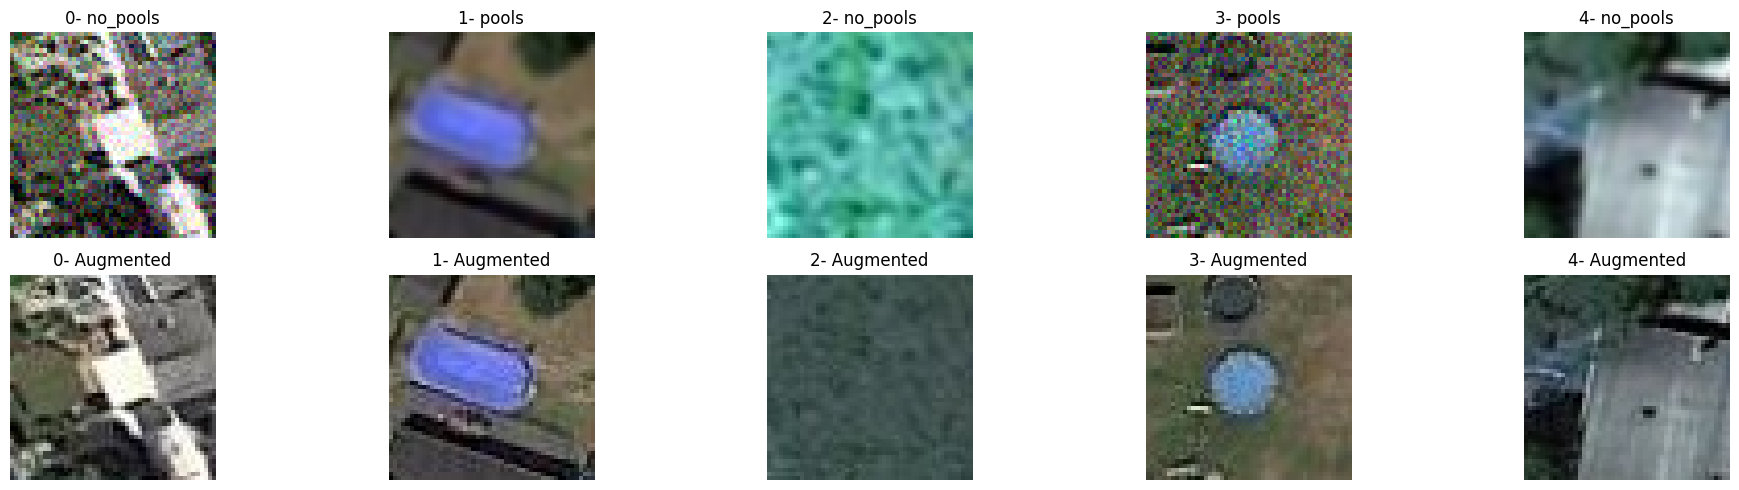

In [30]:
if PLOT_RESULTS:
    compare_augmented_images(augmented_train_images)

In [31]:
train_images = [*train_images, *[augmented_image[:3] for augmented_image in augmented_train_images]]

### **Features**

##### **Filtros de Gabor**

In [32]:
# https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/

def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 16
    ksize = 35  # The local area to evaluate
    sigma = 3.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

In [33]:
gfilters = create_gaborfilter()
train_images = [(x[0], apply_filter(x[1], gfilters), x[2]) for x in train_images]
dev_images = [(x[0], apply_filter(x[1], gfilters), x[2]) for x in dev_images]

In [34]:
if PLOT_RESULTS:
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    for i, (image_dir, image, label) in enumerate(train_images[:8]):
        row_idx = 0 if i < 4 else 1
        col_idx = i if i < 4 else i - 4
        ax[row_idx, col_idx].imshow(image)
        ax[row_idx, col_idx].set_title(label)
        ax[row_idx, col_idx].axis('off')

#### **Features a nivel de canal**

**Medidas de tendencia central**

In [35]:
def calculate_mean(image_gray: np.ndarray):
    return image_gray.mean()

def calculate_median(image_gray: np.ndarray):
    return np.median(image_gray)

def calculate_mode(image_gray: np.ndarray):
    counts = [0] * 256
    for row in image_gray:
        for pixel in row:
            counts[pixel] += 1
    return np.argmax(counts)

**Medidas de dispersión**

In [36]:
def calculate_std(image_gray: np.ndarray):
    return image_gray.std()

**Quantiles**

In [37]:
def calculate_min(image_gray: np.ndarray):
    return image_gray.min()

def calculate_max(image_gray: np.ndarray):
    return image_gray.max()

def calculate_range(image_gray: np.ndarray):
    return image_gray.max() - image_gray.min()

def calculate_quantile(image_gray: np.ndarray, q: float):
    bin_count = 256
    hist, bin_edges = np.histogram(image_gray, bins=bin_count)
    cum_values = np.cumsum(hist * np.diff(bin_edges))
    quantile = np.interp(q * 100, cum_values, bin_edges[:-1])
    return quantile

def calculate_iqr(image_gray: np.ndarray):
    return calculate_quantile(image_gray, 0.75) - calculate_quantile(image_gray, 0.25)

**Probabilidad**

In [38]:
def entropy(image_gray: np.ndarray):
    hist, _ = np.histogram(image_gray, bins=256)
    hist = hist[hist != 0]
    prob = hist / hist.sum()
    return -np.sum(prob * np.log2(prob))

def calculate_skewness(image_gray: np.ndarray):
    return scipy.stats.skew(image_gray, axis=None)

def calculate_kurtosis(image_gray: np.ndarray):
    return scipy.stats.kurtosis(image_gray, axis=None)

In [39]:
model_channel_feature_functions = {
    'mean': calculate_mean,
    'std': calculate_std,
    'median': calculate_median,
    'mode': calculate_mode,
    'min': calculate_min,
    'max': calculate_max,
    'range': calculate_range,
    'skewness': calculate_skewness,
    'kurtosis': calculate_kurtosis,
    'entropy': entropy,
    'quantile_0.25': lambda img: calculate_quantile(img, q=0.25),
    'quantile_0.75': lambda img: calculate_quantile(img, q=0.75),
    'iqr': calculate_iqr,
}

In [40]:
def create_channel_feature_df(images, model_feature_functions, include_grayscale=True):
    channels = ['red', 'green', 'blue'] + (['grayscale'] if include_grayscale else [])
    pixels_df = {'image_id': [], 'feature_name': [], 'feature_value': [], 'label': [], 'channel': []}

    for id, image, label in images:
        for feature_name, feature_function in model_feature_functions.items():
            for chnl in range(3):
                pixels_df['image_id'].append(id)
                pixels_df['feature_value'].append(feature_function(image[:, :, chnl]))
                pixels_df['feature_name'].append(feature_name)
                pixels_df['channel'].append(channels[chnl])
                pixels_df['label'].append(label)

            if include_grayscale:
                pixels_df['image_id'].append(id)
                averaged_image = np.clip(image.mean(axis=2).astype(int), 0, 255)
                pixels_df['feature_value'].append(feature_function(averaged_image))
                pixels_df['feature_name'].append(feature_name)
                pixels_df['channel'].append('grayscale')
                pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [41]:
def scale_feature_df(channel_feature_df: pd.DataFrame):
    channel_feature_df = channel_feature_df.copy()
    for feature_name in channel_feature_df['feature_name'].unique():
        feature_values = channel_feature_df[channel_feature_df['feature_name'] == feature_name]['feature_value']
        current_features_max = feature_values.max()
        current_features_min = feature_values.min()
        feature_values = (feature_values - current_features_min) / (current_features_max - current_features_min)
        channel_feature_df.loc[channel_feature_df['feature_name'] == feature_name, 'feature_value'] = feature_values
    return channel_feature_df

In [42]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'channel_feature_df.csv')):
    channel_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'channel_feature_df.csv'))
    dev_channel_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_channel_feature_df.csv'))
else:
    channel_feature_df = create_channel_feature_df(train_images, model_channel_feature_functions)
    channel_feature_df.to_csv(os.path.join(FEATURES_DIR, 'channel_feature_df.csv'), index=False)
    dev_channel_feature_df = create_channel_feature_df(dev_images, model_channel_feature_functions)
    dev_channel_feature_df.to_csv(os.path.join(FEATURES_DIR, 'dev_channel_feature_df.csv'), index=False)

#### **Visualización de Datos**

##### **Separando por canal**

**Distribución de features (nivel general)**

In [43]:
def plot_histogram_features_violinplot(feature_df: pd.DataFrame):
    _, ax = plt.subplots(nrows=len(feature_df['channel'].unique()), figsize=(20, 20))
    for i, channel in enumerate(feature_df['channel'].unique()):
        current_feature_df = feature_df[feature_df['channel'] == channel]
        scaled_feature_df = scale_feature_df(current_feature_df)
        sns.violinplot(data=scaled_feature_df, x='feature_name', y='feature_value', hue='label', ax=ax[i])
        ax[i].legend(fontsize=10)
        ax[i].set_title(channel)
        plt.tight_layout()

In [44]:
if PLOT_RESULTS:
    plot_histogram_features_violinplot(channel_feature_df)

**Distribución de features (nivel individual)**

In [45]:
def plot_channel_feature_df(pixels_df, color='red', secondary_color='blue', width=None, height=None):
    facet_grid = sns.displot(pixels_df, x='feature_value', hue='label', row='feature_name', col='channel', fill=True, palette=[secondary_color, color], kind='kde')
    facet_grid.fig.set_figwidth(width) if width else None
    facet_grid.fig.set_figheight(height) if height else None
    plt.legend(fontsize=10)

In [46]:
if PLOT_RESULTS:
    for feature_name in model_channel_feature_functions.keys():
        current_feature_df = channel_feature_df[channel_feature_df['feature_name'] == feature_name]
        plot_channel_feature_df(current_feature_df, color='red', secondary_color='blue')

##### **Features de histograma**

In [47]:
def calculate_mean_histogram(histogram: np.ndarray, numBins: int):
    return np.sum((np.arange(numBins) / numBins) * histogram)

def calculate_std_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    return np.sqrt(np.sum(((np.arange(numBins) / numBins) - mean) ** 2 * histogram))

def calculate_median_histogram(histogram: np.ndarray, _: int):
    cumsum = np.cumsum(histogram)
    return np.argmax(cumsum >= cumsum[-1] / 2)

def calculate_mode_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram)

def calculate_min_histogram(histogram: np.ndarray, _: int):
    return np.argmin(histogram)

def calculate_max_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram)

def calculate_range_histogram(histogram: np.ndarray, _: int):
    return np.argmax(histogram) - np.argmin(histogram)

def calculate_quantile_histogram(histogram: np.ndarray, numBins: int, q: float):
    cum_values = np.cumsum(histogram)
    quantile = np.interp(q * 100, cum_values, np.arange(numBins))
    return quantile

def calculate_iqr_histogram(histogram: np.ndarray, numBins: int):
    return calculate_quantile_histogram(histogram, numBins, q=0.75) - calculate_quantile_histogram(histogram, numBins, q=0.25)

def calculate_skewness_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    skewness = np.sum(((histogram - mean)**3) * histogram)
    return skewness

def calculate_kurtosis_histogram(histogram: np.ndarray, numBins: int):
    mean = calculate_mean_histogram(histogram, numBins)
    kurtosis = np.sum(((histogram - mean)**4) * histogram)
    return kurtosis

def calculate_uniformity_histogram(histogram: np.ndarray, _: int):
    return np.sum(histogram ** 2)

def calculate_entropy_histogram(histogram: np.ndarray, numBins: int):
    entropy = -np.sum(histogram * np.log2(histogram + 1e-12)) / np.log2(numBins)
    return entropy

def calculate_R_histogram(histogram: np.ndarray, _: int):
    R = 1 - 1 / (1 + np.std(histogram)**2)
    return R

In [48]:
model_histogram_feature_functions = {
    'mean': calculate_mean_histogram,
    'std': calculate_std_histogram,
    'median': calculate_median_histogram,
    'mode': calculate_mode_histogram,
    'min': calculate_min_histogram,
    'max': calculate_max_histogram,
    'range': calculate_range_histogram,
    'skewness': calculate_skewness_histogram,
    'kurtosis': calculate_kurtosis_histogram,
    'uniformity': calculate_uniformity_histogram,
    'entropy': calculate_entropy_histogram,
    'R': calculate_R_histogram, 
    # 'quantile_0.25': lambda hist, numBins: calculate_quantile_histogram(hist, numBins, q=0.25),
    # 'quantile_0.75': lambda hist, numBins: calculate_quantile_histogram(hist, numBins, q=0.75),
    # 'iqr': calculate_iqr_histogram,
}

In [49]:
def to_grayscale(images: list[tuple]):
    return [(
        id, 
        np.clip(image.mean(axis=2).astype(int), 0, 255), 
        label
    ) for id, image, label in images]

def to_histogram(image_gray: np.ndarray, bins: int = 256):
    hist, _ = np.histogram(image_gray, bins=bins, density=True)
    return hist

In [50]:
def create_histogram_features_df(images: list[tuple], model_histogram_feature_functions: dict, bins=256):
    pixels_df = {'image_id': [], 'feature_name': [], 'feature_value': [], 'label': []}
    grayscale_images = to_grayscale(images)

    for id, image, label in grayscale_images:
        image_histogram = to_histogram(image, bins=bins)

        for feature_name, feature_function in model_histogram_feature_functions.items():
            pixels_df['image_id'].append(id)
            pixels_df['feature_value'].append(feature_function(image_histogram, bins))
            pixels_df['feature_name'].append(feature_name)
            pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [51]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'histogram_feature_df.csv')):
    histogram_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'histogram_feature_df.csv'))
    dev_histogram_feature_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_histogram_feature_df.csv'))
else:
    histogram_feature_df = create_histogram_features_df(train_images, model_histogram_feature_functions)
    histogram_feature_df.to_csv(os.path.join(FEATURES_DIR, 'histogram_feature_df.csv'), index=False)
    dev_histogram_feature_df = create_histogram_features_df(dev_images, model_histogram_feature_functions)
    dev_histogram_feature_df.to_csv(os.path.join(FEATURES_DIR, 'dev_histogram_feature_df.csv'), index=False)

In [52]:
def plot_features_violinplot(feature_df: pd.DataFrame):
    _, ax = plt.subplots(nrows=1, figsize=(20, 5))
    feature_df = scale_feature_df(feature_df)
    sns.violinplot(data=feature_df, x='feature_name', y='feature_value', hue='label', ax=ax)
    ax.legend(fontsize=10)
    plt.tight_layout()

In [53]:
if PLOT_RESULTS:
    plot_features_violinplot(histogram_feature_df)

In [54]:
def plot_feature_df(pixels_df, color='red', secondary_color='blue', width=None, height=None):
    facet_grid = sns.displot(pixels_df, x='feature_value', hue='label', fill=True, palette=[secondary_color, color], kind='kde')
    facet_grid.fig.set_figwidth(width) if width else None
    facet_grid.fig.set_figheight(height) if height else None
    plt.legend(fontsize=10)

In [55]:
if PLOT_RESULTS:
    for feature_name in model_histogram_feature_functions.keys():
        current_feature_df = histogram_feature_df[histogram_feature_df['feature_name'] == feature_name]
        plot_feature_df(current_feature_df, color='red', secondary_color='blue')

##### **Matriz de correlación**

In [57]:
def create_coocurrence_matrix_df(images: list[tuple], distance, angle, levels=256):
    pixels_df = {'image_id': [], 'feature_name': [], 'feature_value': [], 'label': []}
    grayscale_images = to_grayscale(images)

    for id, image, label in grayscale_images:
        co_occurrence_matrix = graycomatrix(
            image, 
            [distance], 
            [angle], 
            levels=levels, 
            normed=True,
            symmetric=True,
        )

        for feature in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
            pixels_df['image_id'].append(id)
            pixels_df['feature_value'].append(graycoprops(co_occurrence_matrix, feature)[0, 0])
            pixels_df['feature_name'].append(feature)
            pixels_df['label'].append(label)

    df = pd.DataFrame(pixels_df)
    df['feature_value'] = df['feature_value'].astype(float)
    return df

In [58]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv')):
    coocurrence_matrix_df = pd.read_csv(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv'))
    dev_coocurrence_matrix_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_coocurrence_matrix_df.csv'))
else:
    coocurrence_matrix_df = create_coocurrence_matrix_df(train_images, distance=1, angle=0)
    coocurrence_matrix_df.to_csv(os.path.join(FEATURES_DIR, 'coocurrence_matrix_df.csv'), index=False)
    dev_coocurrence_matrix_df = create_coocurrence_matrix_df(dev_images, distance=1, angle=0)
    dev_coocurrence_matrix_df.to_csv(os.path.join(FEATURES_DIR, 'dev_coocurrence_matrix_df.csv'), index=False)

In [59]:
if PLOT_RESULTS:
    plot_features_violinplot(coocurrence_matrix_df)

In [60]:
coocurrence_matrix_df.head()

,image_id,feature_name,feature_value,label
0,..\data\train\no_pools\img508.jpg,contrast,3.039592,no_pools
1,..\data\train\no_pools\img508.jpg,dissimilarity,1.236327,no_pools
2,..\data\train\no_pools\img508.jpg,homogeneity,0.538893,no_pools
3,..\data\train\no_pools\img508.jpg,energy,0.128500,no_pools
4,..\data\train\no_pools\img508.jpg,correlation,0.872108,no_pools


In [61]:
if PLOT_RESULTS:
    for feature_name in coocurrence_matrix_df['feature_name'].unique():
        current_feature_df = coocurrence_matrix_df[coocurrence_matrix_df['feature_name'] == feature_name]
        plot_feature_df(current_feature_df, color='red', secondary_color='blue')

##### **SIFT, SURF, HOG, GAVOR**

### **Unir features**

In [62]:
def rename_feature(feature_name: str, suffix: str):
    return feature_name + '_' + suffix
    
def ingest_features(channel_features: pd.DataFrame, histogram_features: pd.DataFrame, coocurrence_matrix_features: pd.DataFrame):
    channel_feature_columns = [rename_feature(row['feature_name'], row['channel']) for _, row in channel_features.iterrows()]
    histogram_feature_columns = [rename_feature(row['feature_name'], 'histogram') for _, row in histogram_features.iterrows()]
    coocurrence_matrix_feature_columns = [rename_feature(row['feature_name'], 'coocurrence_matrix') for _, row in coocurrence_matrix_features.iterrows()]
    feature_columns = [*channel_feature_columns, *histogram_feature_columns, *coocurrence_matrix_feature_columns,]
    image_initial_features = {**{feature_name: None for feature_name in feature_columns}, 'label': None}
    image_features = {image_id: image_initial_features.copy() for image_id in channel_features['image_id'].unique()}
    ingested_df = {'image_id': [], **{feature_name: [] for feature_name in feature_columns}, 'label': []}
    visited_images = set()

    # Individual datasets
    for _, row in channel_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], row['channel'])
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value
        if image_id not in visited_images:
            image_features[image_id]['label'] = row['label']
            visited_images.add(image_id)

    for _, row in histogram_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], 'histogram')
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value

    for _, row in coocurrence_matrix_features.iterrows():
        image_id = row['image_id']
        renamed_feature = rename_feature(row['feature_name'], 'coocurrence_matrix')
        feature_value = row['feature_value']
        image_features[image_id][renamed_feature] = feature_value

    # Mixed dataset
    for image_id, features in image_features.items():
        for feature_name, feature_values in features.items():
            ingested_df[feature_name].append(feature_values) if feature_name != 'label' else None
        ingested_df['image_id'].append(image_id)
        ingested_df['label'].append(features['label'])


    return pd.DataFrame(ingested_df)

In [63]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'ingested_features_df.csv')):
    ingested_features_df = pd.read_csv(os.path.join(FEATURES_DIR, 'ingested_features_df.csv'))
    dev_ingested_features_df = pd.read_csv(os.path.join(FEATURES_DIR, 'dev_ingested_features_df.csv'))
else:
    ingested_features_df = ingest_features(channel_feature_df, histogram_feature_df, coocurrence_matrix_df)
    ingested_features_df.to_csv(os.path.join(FEATURES_DIR, 'ingested_features_df.csv'), index=False)
    dev_ingested_features_df = ingest_features(dev_channel_feature_df, dev_histogram_feature_df, dev_coocurrence_matrix_df)
    dev_ingested_features_df.to_csv(os.path.join(FEATURES_DIR, 'dev_ingested_features_df.csv'), index=False)

#### **Tests de normalidad**

In [64]:
def shapiro_wilk_test(features: pd.Series):
    _, pvalue = scipy.stats.shapiro(features)
    return pvalue

def anderson_darling_test(features: pd.Series):
    statistic, critical_values, significance_levels = scipy.stats.anderson(features)
    for critical_value, significance_level in zip(critical_values[::-1], significance_levels[::-1]):
        if statistic > critical_value:
            return significance_level / 100
    return significance_levels[0] / 100

def create_normality_df(features_df: pd.DataFrame, test='shapiro_wilk'):
    test_functions = {'anderson_darling': anderson_darling_test, 'shapiro_wilk': shapiro_wilk_test}
    normality_df = {'feature_name': [], 'pvalue': [], 'is_normal': []}
    categorical_features = features_df.select_dtypes(include='object').columns
    for feature_name in features_df.columns:
        if feature_name not in categorical_features:
            pvalue = test_functions[test](features_df[feature_name])
            normality_df['feature_name'].append(feature_name)
            normality_df['pvalue'].append(pvalue)
            normality_df['is_normal'].append(pvalue > 0.05)
    return pd.DataFrame(normality_df)

In [65]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'normality_df.csv')):
    normality_df = pd.read_csv(os.path.join(FEATURES_DIR, 'normality_df.csv'))
else:
    normality_df = create_normality_df(ingested_features_df)
    normality_df.to_csv(os.path.join(FEATURES_DIR, 'normality_df.csv'), index=False)

In [66]:
def plot_normality_df(normality_df: pd.DataFrame, scale='log'):
    _, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(data=normality_df, x='feature_name', y='pvalue', hue='is_normal', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.plot([0, len(normality_df)-1], [0.05, 0.05], linewidth=2, color='red')
    plt.yscale(scale)
    plt.tight_layout()

In [67]:
if PLOT_RESULTS:
    plot_normality_df(normality_df)

### **Correlación de features**

In [68]:
ingested_features_df.head()

,image_id,mean_red,mean_green,mean_blue,mean_grayscale,std_red,std_green,std_blue,std_grayscale,median_red,...,kurtosis_histogram,uniformity_histogram,entropy_histogram,R_histogram,contrast_coocurrence_matrix,dissimilarity_coocurrence_matrix,homogeneity_coocurrence_matrix,energy_coocurrence_matrix,correlation_coocurrence_matrix,label
0,..\data\train\no_pools\img508.jpg,55.4896,82.2284,64.3704,67.0356,3.321369,3.387541,4.426963,3.501533,55.0,...,1297.597093,8.144488,0.647537,0.029442,3.039592,1.236327,0.538893,0.128500,0.872108,no_pools
1,..\data\train\no_pools\img824.jpg,96.4732,114.6464,117.7484,109.2992,48.202785,46.335996,52.210377,48.552587,88.0,...,0.025538,0.012681,0.979681,0.000030,44.738367,4.571837,0.272742,0.041696,0.990545,no_pools
2,..\data\train\no_pools\img247.jpg,50.4156,52.0484,50.6500,50.7016,15.807456,14.788822,16.294867,15.525429,45.0,...,0.226988,0.267356,1.383300,0.000920,10.159184,2.262857,0.380013,0.069578,0.979087,no_pools
3,..\data\train\no_pools\img165.jpg,153.1428,152.8592,144.9488,150.0104,55.846389,54.696561,57.429983,55.628280,143.0,...,0.151473,0.016784,1.059779,0.000043,203.780000,8.940816,0.200777,0.060037,0.967134,no_pools
4,..\data\train\pools\img736.jpg,178.7056,177.0012,167.3580,174.0376,53.080872,54.476575,57.100300,53.742402,164.0,...,0.476809,0.015912,1.167708,0.000033,129.957959,6.703265,0.227082,0.039188,0.977351,pools


##### **Coeficiente de correlación**

In [69]:
def plot_feature_correlation(feature_df: pd.DataFrame, threshold: float=None, normal=False):
    _, ax = plt.subplots(figsize=(15, 15))
    method = 'pearson' if normal else 'spearman'
    corr = feature_df.corr(numeric_only=True, method=method).abs()
    if threshold:
        corr[corr < threshold] = 0
        corr[corr >= threshold] = 1
    sns.heatmap(corr, annot=False, ax=ax) 

In [70]:
if PLOT_RESULTS:
    plot_feature_correlation(ingested_features_df)

In [71]:
if PLOT_RESULTS:
    plot_feature_correlation(ingested_features_df, threshold=0.6)

##### **Pairplot**

In [72]:
def pairplot_features(feature_df: pd.DataFrame, label: str):
    sns.pairplot(feature_df, hue=label)

## **Significancia**

In [73]:
def create_mutual_info_df(X, y, descriptors):
    mutual_info_statistics = mutual_info_classif(X, y, random_state=0)
    mutual_info_df = pd.DataFrame({'importance': mutual_info_statistics}, index=descriptors)
    mutual_info_df.sort_values(by='importance', ascending=False, inplace=True)
    return mutual_info_df

In [74]:
if USE_CACHE and os.path.exists(os.path.join(FEATURES_DIR, 'mutual_info_df.csv')):
    mutual_info_df = pd.read_csv(os.path.join(FEATURES_DIR, 'mutual_info_df.csv'), index_col='feature_name')
else:
    numeric_features = ingested_features_df.select_dtypes(include='number').columns
    X = ingested_features_df[numeric_features]
    y = ingested_features_df['label']
    mutual_info_df = create_mutual_info_df(X, y, numeric_features)
    mutual_info_df.to_csv(os.path.join(FEATURES_DIR, 'mutual_info_df.csv'), index=True, index_label='feature_name')

In [75]:
def plot_mutual_info_df(importances_df: pd.DataFrame):
    _, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(data=importances_df, x=importances_df.index, y='importance', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()

In [76]:
if PLOT_RESULTS:
    plot_mutual_info_df(mutual_info_df)

##### **Pairplot**

In [77]:
def pairplot_features(feature_df: pd.DataFrame, label: str):
    sns.pairplot(feature_df, hue=label)

In [78]:
ingested_features_df.head()

,image_id,mean_red,mean_green,mean_blue,mean_grayscale,std_red,std_green,std_blue,std_grayscale,median_red,...,kurtosis_histogram,uniformity_histogram,entropy_histogram,R_histogram,contrast_coocurrence_matrix,dissimilarity_coocurrence_matrix,homogeneity_coocurrence_matrix,energy_coocurrence_matrix,correlation_coocurrence_matrix,label
0,..\data\train\no_pools\img508.jpg,55.4896,82.2284,64.3704,67.0356,3.321369,3.387541,4.426963,3.501533,55.0,...,1297.597093,8.144488,0.647537,0.029442,3.039592,1.236327,0.538893,0.128500,0.872108,no_pools
1,..\data\train\no_pools\img824.jpg,96.4732,114.6464,117.7484,109.2992,48.202785,46.335996,52.210377,48.552587,88.0,...,0.025538,0.012681,0.979681,0.000030,44.738367,4.571837,0.272742,0.041696,0.990545,no_pools
2,..\data\train\no_pools\img247.jpg,50.4156,52.0484,50.6500,50.7016,15.807456,14.788822,16.294867,15.525429,45.0,...,0.226988,0.267356,1.383300,0.000920,10.159184,2.262857,0.380013,0.069578,0.979087,no_pools
3,..\data\train\no_pools\img165.jpg,153.1428,152.8592,144.9488,150.0104,55.846389,54.696561,57.429983,55.628280,143.0,...,0.151473,0.016784,1.059779,0.000043,203.780000,8.940816,0.200777,0.060037,0.967134,no_pools
4,..\data\train\pools\img736.jpg,178.7056,177.0012,167.3580,174.0376,53.080872,54.476575,57.100300,53.742402,164.0,...,0.476809,0.015912,1.167708,0.000033,129.957959,6.703265,0.227082,0.039188,0.977351,pools


In [79]:
if PLOT_RESULTS:
    top_feature_columns = list(mutual_info_df.index[0:10]) + ['label']
    pairplot_features(ingested_features_df[top_feature_columns], label='label')

In [80]:
if PLOT_RESULTS:
    out_of_mutual_info_top_feature_columns = list(mutual_info_df.index[10:20]) + ['label']
    pairplot_features(ingested_features_df[out_of_mutual_info_top_feature_columns], label='label')

#### **Prueba con clasificadores**

In [81]:
def create_datasets(train_df: pd.DataFrame, dev_df: pd.DataFrame, chosen_columns: list[str], label_column: str):
    train_X = train_df[chosen_columns].drop(columns=[label_column])
    train_y = train_df[label_column]
    dev_X = dev_df[chosen_columns].drop(columns=[label_column])
    dev_y = dev_df[label_column]
    return train_X, train_y, dev_X, dev_y

def create_pipeline(model, scaler=None):
    if scaler:
        return Pipeline([('scaler', scaler), ('model', model)])
    return Pipeline([('model', model)])

def create_model(seed=SEED) -> BaseEstimator:
    return SVC(random_state=seed)

**Nuestro modelo**

In [82]:
print("Cantidad de features:", len(mutual_info_df.index))

Cantidad de features: 69


In [83]:
top_feature_columns = list(mutual_info_df.index[0:]) + ['label']
train_X, train_y, dev_X, dev_y = create_datasets(ingested_features_df, dev_ingested_features_df, top_feature_columns, 'label')

In [84]:
model = create_model()
scaler = StandardScaler()
pipeline = create_pipeline(model, scaler)

In [85]:
pipeline.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC(random_state=2))])

In [86]:
pipeline.score(train_X, train_y), pipeline.score(dev_X, dev_y)

(0.8882450331125827, 0.9120521172638436)

Antes de escalar: (0.8990066225165563, 0.9120521172638436)

**Pixeles como features**

In [89]:
train_X = [image[1] for image in train_images]
train_X = [image.flatten() for image in train_X]
train_y = [image[2] for image in train_images]
dev_X = [image[1] for image in dev_images]
dev_X = [image.flatten() for image in dev_X]
dev_y = [image[2] for image in dev_images]

In [90]:
model = create_model()
scaler = StandardScaler()
pipeline2 = create_pipeline(model, scaler=scaler)
pipeline2.fit(train_X, train_y)
pipeline2.score(train_X, train_y), pipeline2.score(dev_X, dev_y)

(0.9769283746556474, 0.8794788273615635)